# Aerial Image RGB Mask UNET


https://arxiv.org/pdf/1505.04597.pdf

In [1]:
!pip install imantics --quiet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import json
import os
import imantics
from PIL import Image
from skimage.transform import resize
import random
from sklearn.model_selection import train_test_split
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
base_dir = '/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 1'
images_dir = f'{base_dir}/images' 
masks_dir = f'{base_dir}/masks' 

In [4]:
images_listdir = os.listdir(images_dir)[0:20]
random_images = np.random.choice(images_listdir, size = 9, replace = False)

In [5]:
image_size=512
input_image_size=(512,512)

In [6]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size))
    return img

# Input images 

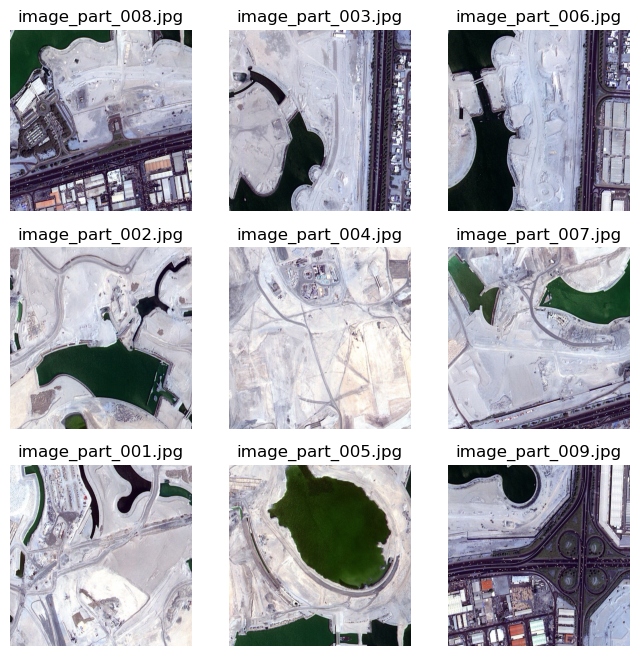

In [7]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (8,8))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{images_dir}/{random_images[i]}")
        #print(img.shape)
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

# Ground truth masks

    fig, ax = plt.subplots(rows, cols, figsize = (8,8))
    for i, ax in enumerate(ax.flat):
        if i < len(random_images):
            file=random_images[i][0:-4]+'.png'
            img = read_image(f"{masks_dir}/{file}")
            #print(img.shape)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            #print(img.shape)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')

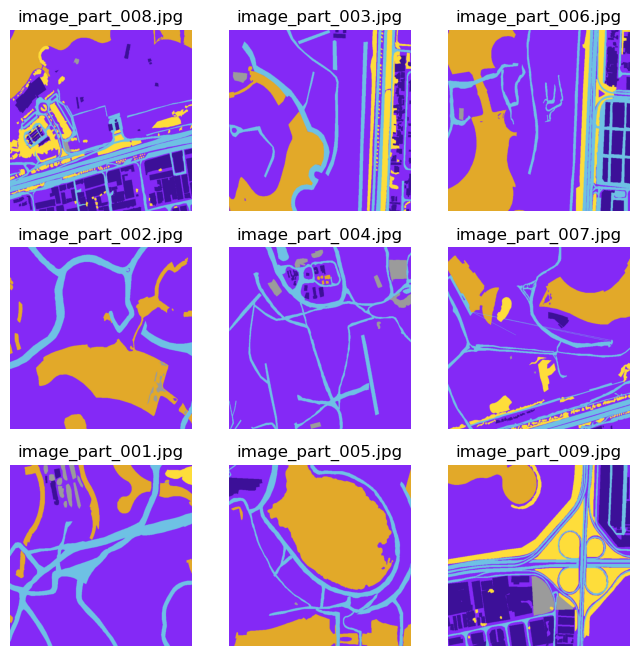

In [8]:
fig, ax = plt.subplots(rows, cols, figsize = (8,8))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i][0:-4]+'.png'
        img = read_image(f"{masks_dir}/{file}")
        #print(img.shape)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #print(set(img.flatten()))
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

In [9]:
#MASKS=np.zeros((1,image_size, image_size, 1), dtype=bool) 
MASKS=np.zeros((1,image_size, image_size, 3),dtype=np.uint8) #####
IMAGES=np.zeros((1,image_size, image_size, 3),dtype=np.uint8)

for j,file in enumerate(images_listdir[0:81]): ##the smaller, the faster
    #print(j)
    image = read_image(f"{images_dir}/{file}")
    image_ex = np.expand_dims(image, axis=0)
    IMAGES = np.vstack([IMAGES, image_ex])
    
    file2=file[0:-4]+'.png'
    mask = read_image(f"{masks_dir}/{file2}")
    #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB) #####
    #mask = mask.reshape(512,512,1) #####
    mask_ex = np.expand_dims(mask, axis=0)    
    MASKS = np.vstack([MASKS, mask_ex])


In [10]:
images=np.array(IMAGES)[1:81]
masks=np.array(MASKS)[1:81]
print(images.shape,masks.shape)

(9, 512, 512, 3) (9, 512, 512, 3)


In [11]:
images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.4, random_state=42)

In [12]:
print(len(images_train), len(masks_train))

5 5


# U-Net

In [13]:
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2, 2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)

    outputs = tf.keras.layers.Conv2D(3, 1, padding="same", activation="sigmoid")(decode4) #####

    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

unet_model = Unet((512,512,3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Train

In [ ]:
unet_result = unet_model.fit(
    images_train, masks_train, 
    validation_split = 0.2, batch_size = 4, epochs = 160)

Epoch 1/160
1/1 [==============================] - 80s 80s/step - loss: -25.0503 - accuracy: 0.3316 - val_loss: 8.3767 - val_accuracy: 0.3118
Epoch 2/160
1/1 [==============================] - 69s 69s/step - loss: -85.2381 - accuracy: 0.6866 - val_loss: -41.8890 - val_accuracy: 0.5386
Epoch 3/160
1/1 [==============================] - 69s 69s/step - loss: -133.2407 - accuracy: 0.7601 - val_loss: 3356.0967 - val_accuracy: 0.1197
Epoch 4/160
1/1 [==============================] - 69s 69s/step - loss: -166.5134 - accuracy: 0.7759 - val_loss: 17155.6562 - val_accuracy: 0.1235
Epoch 5/160
1/1 [==============================] - 69s 69s/step - loss: -192.4836 - accuracy: 0.7919 - val_loss: 49166.1953 - val_accuracy: 0.1472
Epoch 6/160
1/1 [==============================] - 69s 69s/step - loss: -211.0630 - accuracy: 0.8071 - val_loss: 72773.0312 - val_accuracy: 0.1270
Epoch 7/160
1/1 [==============================] - 69s 69s/step - loss: -225.7139 - accuracy: 0.8112 - val_loss: 86400.0000 - v

* epochs = 60 bad 
* epochs = 100 getting better
* epochs = 140 getting better
* epochs = 200 getting worse

# Predict

In [ ]:
unet_predict = unet_model.predict(images_test)

In [ ]:
def show_result(idx, og, unet, target, p):
    
    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original "+str(idx))
    axs[0].imshow(og)
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet*0.9)
    axs[1].axis('off')
    
    axs[2].set_title("Ground Truth")
    axs[2].imshow(target)
    axs[2].axis('off')

    plt.show()

In [ ]:
r1,r2,r3,r4=0.7,0.8,0.9,0.99

In [ ]:
unet_predict1 = (unet_predict > r1).astype(np.uint8)
unet_predict2 = (unet_predict > r2).astype(np.uint8)
unet_predict3 = (unet_predict > r3).astype(np.uint8)
unet_predict4 = (unet_predict > r4).astype(np.uint8)

In [ ]:
show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx: 
    show_result(idx, images_test[idx], unet_predict1[idx], masks_test[idx], r1)
    show_result(idx, images_test[idx], unet_predict2[idx], masks_test[idx], r2)
    show_result(idx, images_test[idx], unet_predict3[idx], masks_test[idx], r3)
    show_result(idx, images_test[idx], unet_predict4[idx], masks_test[idx], r4)
    print()